#### Import libraries

In [3]:
import numpy as np
import pandas as pd
import gzip
import idx2numpy
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


np.random.seed(42)
dir_path = os.path.dirname(
    os.path.realpath(os.path.join(os.getcwd()))
)

#### Reading train, test data

In [4]:
with gzip.open(dir_path+"/data/fashion_mnist/train-images-idx3-ubyte.gz", 'rb') as f:
    train_data = idx2numpy.convert_from_file(f)

with gzip.open(dir_path+"/data/fashion_mnist/train-labels-idx1-ubyte.gz", 'rb') as f:
    train_labels = idx2numpy.convert_from_file(f)

In [5]:
with gzip.open(dir_path+"/data/fashion_mnist/t10k-images-idx3-ubyte.gz", 'rb') as f:
    test_data = idx2numpy.convert_from_file(f)

with gzip.open(dir_path+"/data/fashion_mnist/t10k-labels-idx1-ubyte.gz", 'rb') as f:
    test_labels = idx2numpy.convert_from_file(f)

In [6]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

#### Dataset charectiristics

In [7]:
pd.Series(train_labels).nunique(), pd.Series(test_labels).nunique()

(10, 10)

In [8]:
print('Train data labels distribution: ')
pd.Series(train_labels).value_counts()

Train data labels distribution: 


9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
dtype: int64

In [9]:
print('Test data labels distribution: ')
pd.Series(test_labels).value_counts()

Test data labels distribution: 


9    1000
2    1000
1    1000
6    1000
4    1000
5    1000
7    1000
3    1000
8    1000
0    1000
dtype: int64

In [10]:
fashion_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

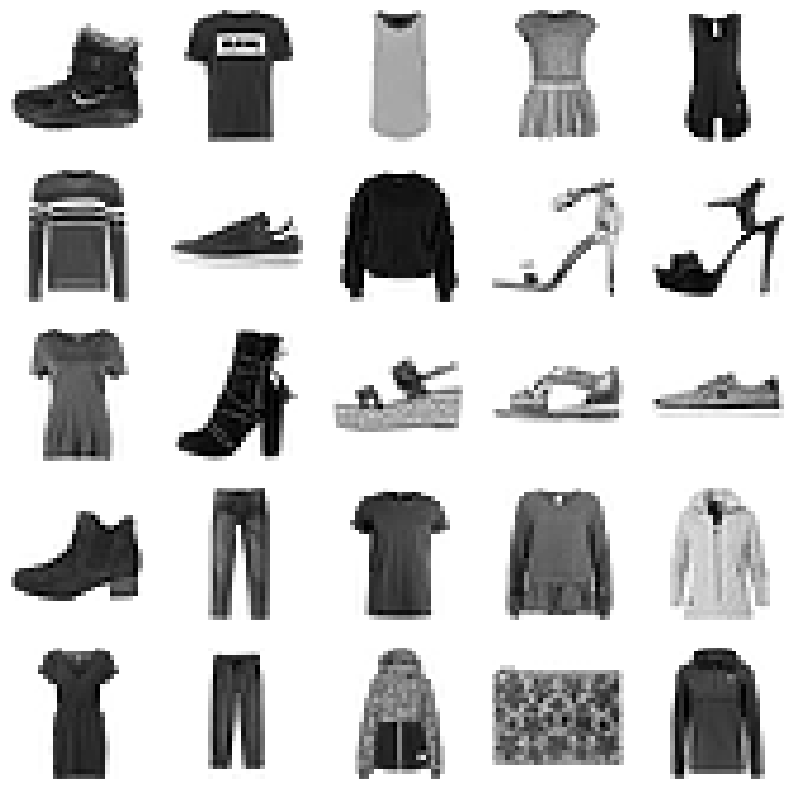

In [11]:
def view_samples():
    plt.figure(figsize=(10, 10))
    for index in range(25):
        plt.subplot(5, 5, index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_data[index].squeeze(), cmap=plt.cm.binary)
        plt.xlabel(f"{fashion_dict[train_labels[index].item()]}, {train_labels[index]}", color='white')
    plt.show()


view_samples()

#### Data preprocessing

In [13]:
class TrainingSet(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.target[index]
        image = self.data[index].astype("float32").reshape((28, 28, 1))
        if self.transform:
            image = self.transform(image)
        return image, label


class TestSet(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.target[index]
        image = self.data[index].astype("float32").reshape((28, 28, 1))
        if self.transform:
            image = self.transform(image)
        return image, label


In [14]:
train_labels = pd.Series(train_labels)
test_labels = pd.Series(test_labels)

In [15]:
training_data = TrainingSet(
    data=train_data, target=train_labels, transform=transforms.ToTensor()
)

test_data = TestSet(
    data=test_data, target=test_labels, transform=transforms.ToTensor()
)

In [16]:
total_train = len(training_data)
train_size = int(0.8 * total_train)
val_size = total_train - train_size  # This ensures all data is used

# Split the data
train_data, val_data = random_split(training_data, [train_size, val_size])

In [17]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")
for X, y in train_loader:
    print("Training batch - X shape:", X.shape, "Y shape:", y.shape)
    break  

for X, y in val_loader:
    print("Validation batch - X shape:", X.shape, "Y shape:", y.shape)
    break  

for X, y in test_loader:
    print("Testing batch - X shape:", X.shape, "Y shape:", y.shape)
    break  

Training batches: 750
Validation batches: 188
Testing batches: 157
Training batch - X shape: torch.Size([64, 1, 28, 28]) Y shape: torch.Size([64])
Validation batch - X shape: torch.Size([64, 1, 28, 28]) Y shape: torch.Size([64])
Testing batch - X shape: torch.Size([64, 1, 28, 28]) Y shape: torch.Size([64])


#### Model training utils

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [19]:
class CNN(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),  # 26 x 26 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3),  # 24 x 24 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 12 x 12 x 32
            nn.Conv2d(32, 64, kernel_size=3),  # 10 x 10 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3),  # 8 x 8 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4 x 4 x 64
            nn.Flatten(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(512, num_labels),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


model = CNN(num_labels=len(fashion_dict))
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.float().to(device), y.long().to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    print(
        f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {average_train_loss:>8f} \n"
    )
    return average_train_loss, train_accuracy

In [21]:
def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.long().to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_val_loss = val_loss / num_batches
    val_accuracy = correct / size
    print(
        f"Validation Error: \n Accuracy: {(100*val_accuracy):>0.1f}%, Validation loss: {average_val_loss:>8f} \n"
    )
    return average_val_loss, val_accuracy

In [22]:
def evaluate_model(loader, model, loss_fn):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.float().to(device), y.long().to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())

    average_loss = total_loss / len(loader)
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    return y_true, y_pred, average_loss, accuracy

#### Model training process

In [25]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
test_losses = []
val_losses = []
train_accs = []
test_accs = []
val_accs = []
epochs = 10
max_acc = 0
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if max_acc < val_acc:
        print(
            f"[SAVING] Validation Accuracy Increased({(100*max_acc):>0.1f}% ---> {(100*val_acc):>0.1f}%)"
        )
        max_acc = val_acc

        # Saving State Dict
        torch.save(model.state_dict(), dir_path+"/model/saved_model.pth")
print("Done!")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 0.135952  [   64/48000]
loss: 0.362436  [ 6464/48000]
loss: 0.258844  [12864/48000]
loss: 0.093470  [19264/48000]
loss: 0.228211  [25664/48000]
loss: 0.340447  [32064/48000]
loss: 0.230161  [38464/48000]
loss: 0.262333  [44864/48000]
Training Error: 
 Accuracy: 90.4%, Avg loss: 0.263044 

Validation Error: 
 Accuracy: 90.9%, Validation loss: 0.254384 

[SAVING] Validation Accuracy Increased(0.0% ---> 90.9%)
Epoch 2
-------------------------------
loss: 0.112024  [   64/48000]
loss: 0.152307  [ 6464/48000]
loss: 0.192739  [12864/48000]
loss: 0.203350  [19264/48000]
loss: 0.122985  [25664/48000]
loss: 0.219455  [32064/48000]
loss: 0.261554  [38464/48000]
loss: 0.265281  [44864/48000]
Training Error: 
 Accuracy: 92.7%, Avg loss: 0.202406 

Validation Error: 
 Accuracy: 90.8%, Validation loss: 0.254993 

Epoch 3
-------------------------------
loss: 0.174474  [   64/48000]
loss: 0.077881  [ 6464/48000]
loss: 0.168997  [12864/48000]
loss: 0.1862

#### Model results

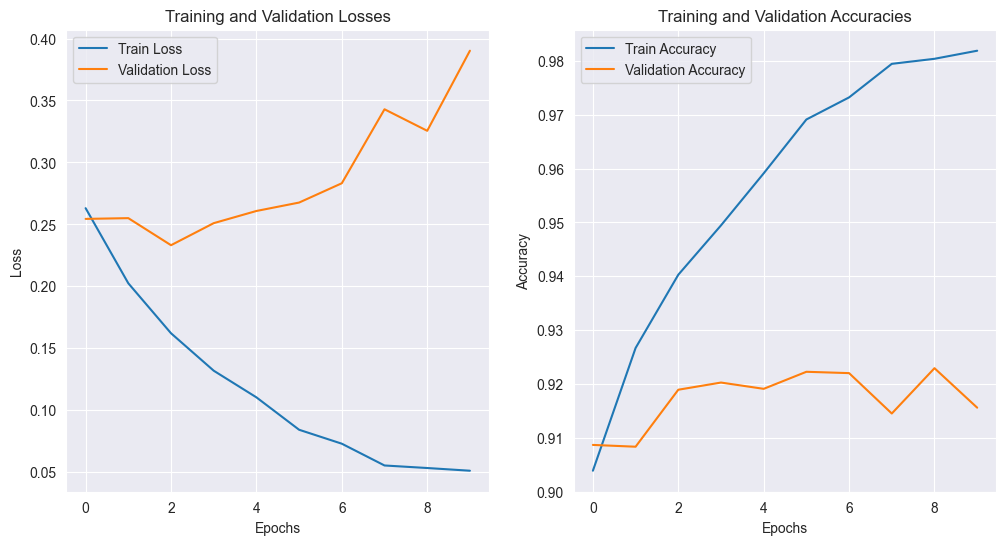

In [26]:
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Training and Validation Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#### Test Model

In [27]:
model.load_state_dict(torch.load(dir_path+"/model/saved_model.pth"))
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_

In [28]:
loss_fn = torch.nn.CrossEntropyLoss()

y_true, y_pred, test_loss, test_accuracy = evaluate_model(test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2706
Test Accuracy: 0.9178


In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.86      0.89      0.88      1000
           3       0.91      0.94      0.92      1000
           4       0.91      0.85      0.88      1000
           5       0.99      0.96      0.98      1000
           6       0.76      0.78      0.77      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



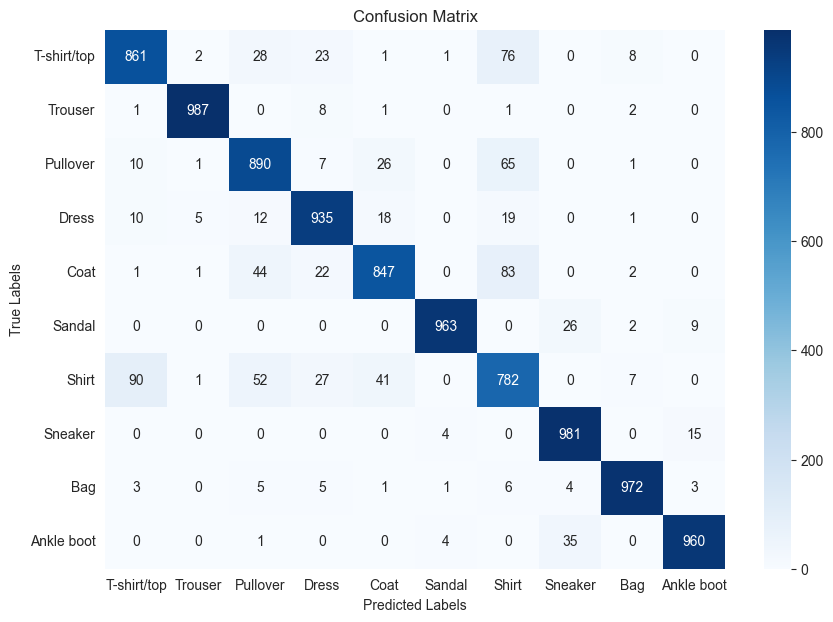

In [30]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(fashion_dict.values()), yticklabels=list(fashion_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

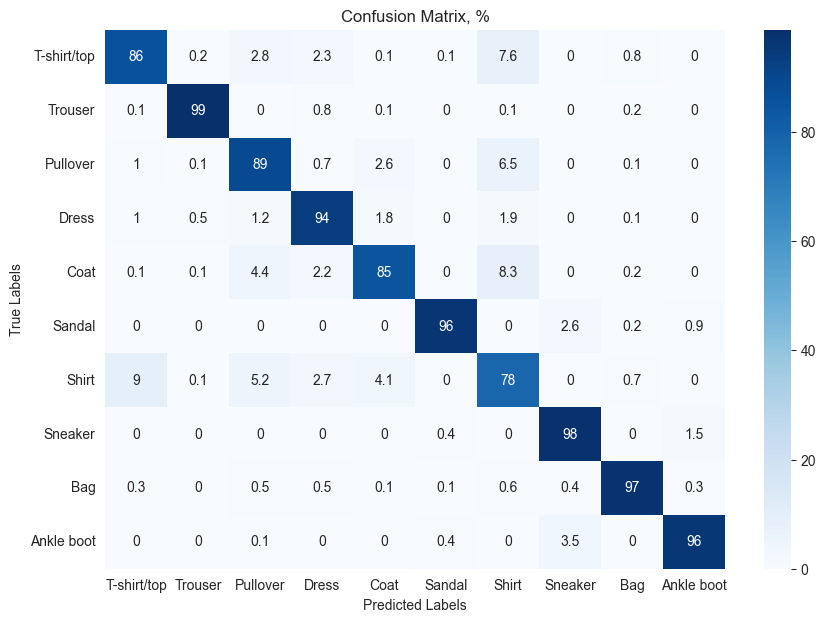

In [31]:
cm = confusion_matrix(y_true, y_pred, normalize='true')*100
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=list(fashion_dict.values()), yticklabels=list(fashion_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix, %')
plt.show()